<a href="https://colab.research.google.com/github/chellij/chellij/blob/main/FYP_RoboflowConnection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15814 (delta 9), reused 23 (delta 2), pack-reused 15768
Receiving objects: 100% (15814/15814), 14.64 MiB | 29.87 MiB/s, done.
Resolving deltas: 100% (10821/10821), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.9/626.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.3 MB/s eta 0:0

In [2]:
import utils
display = utils.notebook_init()  # checks

from roboflow import Roboflow

import numpy as np
import cv2

print("OpenCV-Python Version {}".format(cv2.__version__))

YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/78.2 GB disk)
OpenCV-Python Version 4.7.0


In [3]:
from skimage import io
import matplotlib.pyplot as plt

image = cv2.imread('/content/chess0.jpg')

# reading the sample image from a url
#image = io.imread('/content/chess0.jpg')
#plt.imshow(image)
#plt.show()

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
def take_image(img_name):
  from IPython.display import Image
  try:
    filename = take_photo(img_name)
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

In [6]:
def get_predictions(img_name):

  rf = Roboflow(api_key="r79ZHB2zt3wvu5WZWnd7")
  project = rf.workspace().project("rij-fyp-chess-set-detection")
  model = project.version(1).model

  # infer on a local image
  print(model.predict(img_name, confidence=40, overlap=30).json())

  # save prediction values only
  predictions = model.predict(img_name, confidence=50).json()
  return predictions


In [7]:
def draw_predictions(img_name, predictions, num):
  im = cv2.imread(img_name)

  for bounding_box in predictions['predictions']:
      x0 = bounding_box['x'] - bounding_box['width'] / 2
      x1 = bounding_box['x'] + bounding_box['width'] / 2
      y0 = bounding_box['y'] - bounding_box['height'] / 2
      y1 = bounding_box['y'] + bounding_box['height'] / 2

      start_point = (int(x0), int(y0))
      end_point = (int(x1), int(y1))

      if bounding_box['class'] == 'Pawn':
        colour = (0, 255, 0)
      elif bounding_box['class'] == 'Queen' :
        colour = (0, 0, 255)
      elif bounding_box['class'] == 'King' :
        colour = (255, 0, 0)
      elif bounding_box['class'] == 'Rook' :
        colour = (255, 255, 0)
      elif bounding_box['class'] == 'Bishop' :
        colour = (0, 255, 255)
      elif bounding_box['class'] == 'Knight' :
        colour = (255, 0, 255)
      elif bounding_box['class'] == 'Hand' :
        colour = (50, 50, 50)
      elif bounding_box['class'] == 'Chessboard' :
        colour = (150, 150, 150)
      else :
        colour = (0, 0, 0)

      w = im.shape[0]
      h = im.shape[1]
      scale = 7e-4
      fS=min(w, h) * scale

      cv2.putText(
          im,
          bounding_box["class"],
          (int(x0), int(y0) - 10),
          fontFace = cv2.FONT_HERSHEY_SIMPLEX,
          fontScale = fS,
          color = (255, 255, 255),
          thickness=1
      )

      cv2.rectangle(im, start_point, end_point, color=colour, thickness=2)

  title = "%s%i%s" % ('/content/bb', num, '.jpg')
  cv2.imwrite(title, im)

  cv2_imshow(im)
  print("Image Saved to %s" % title)

<IPython.core.display.Javascript object>

Saved to /content/chessboard.jpg


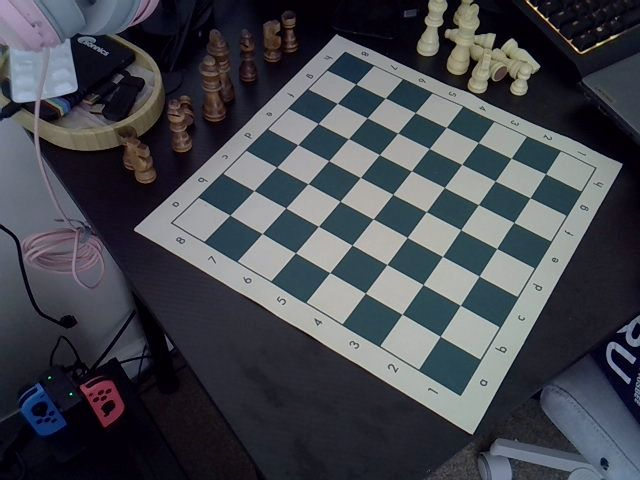

In [8]:
take_image("/content/chessboard.jpg")

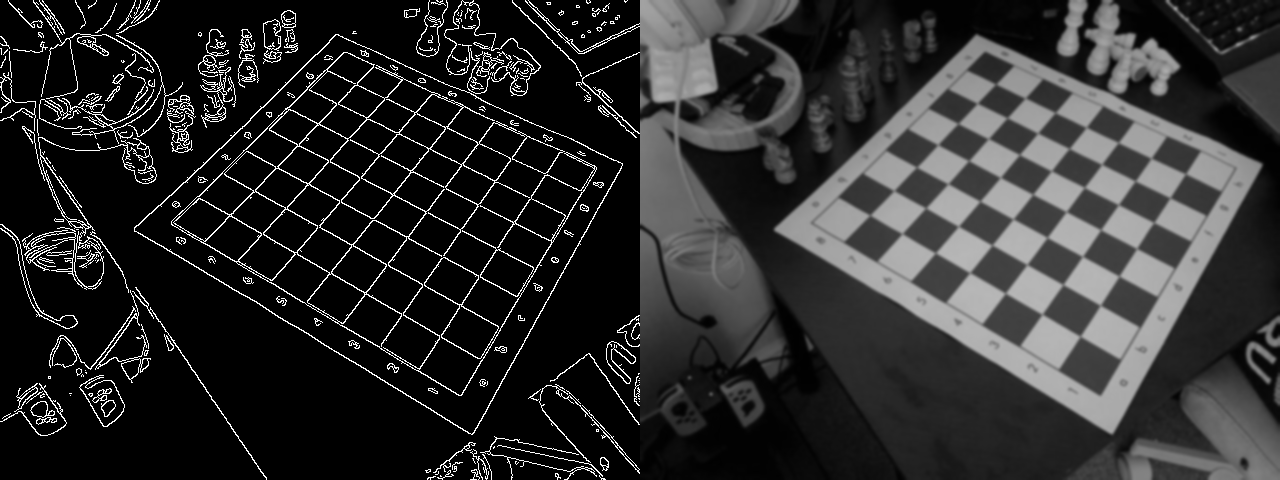

In [11]:
from google.colab.patches import cv2_imshow

orig = cv2.imread("/content/chessboard.jpg")
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Apply edge detection method on the image
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Apply gaussian blur on the image
gauss = cv2.GaussianBlur(orig, [7, 7], 0)

graygauss = cv2.cvtColor(gauss, cv2.COLOR_BGR2GRAY)
cv2_imshow(np.hstack([edges, graygauss]))

[INFO] attempt=0 eps=0.0010, num_pts=102
[INFO] attempt=1 eps=0.0064, num_pts=4
[INFO] attempt=2 eps=0.0119, num_pts=4
[INFO] attempt=3 eps=0.0173, num_pts=4
[INFO] attempt=4 eps=0.0228, num_pts=4
[INFO] attempt=5 eps=0.0282, num_pts=4
[INFO] attempt=6 eps=0.0337, num_pts=4
[INFO] attempt=7 eps=0.0391, num_pts=4
[INFO] attempt=8 eps=0.0446, num_pts=4
[INFO] attempt=9 eps=0.0500, num_pts=4


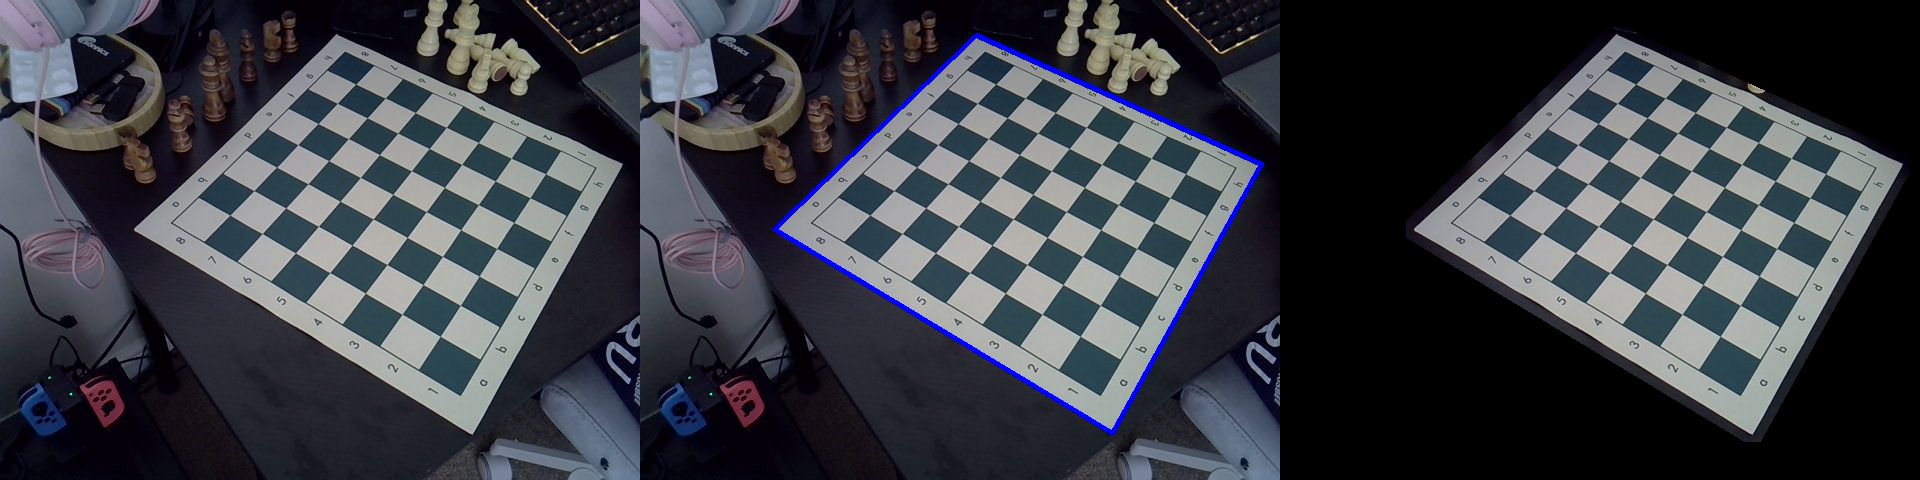

In [12]:
# load the image
image = cv2.imread("/content/chessboard.jpg")

# red color boundaries [B, G, R]
lower = [0, 120, 0]
upper = [180, 200, 255]

# create NumPy arrays from the boundaries
lower = np.array(lower, dtype="uint8")
upper = np.array(upper, dtype="uint8")

# find the colors within the specified boundaries and apply
# the mask
mask = cv2.inRange(image, lower, upper)

ret,thresh = cv2.threshold(mask, 40, 255, 0)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

if len(contours) != 0:

    # find the biggest countour (c) by the area
    c = max(contours, key = cv2.contourArea)

    # to demonstrate the impact of contour approximation, let's loop
    # over a number of epsilon sizes
    i = 0
    for eps in np.linspace(0.001, 0.05, 10):
      # approximate the contour
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, eps * peri, True)
      text = "attempt={} eps={:.4f}, num_pts={}".format(i, eps, len(approx))
      # show the approximated contour image
      print("[INFO] {}".format(text))
      i = i+1

    # draw largest contour onto image
    output = image.copy()
    cv2.drawContours(output, [approx], 0, 255, 3)

    # create a new mask from the area of this largest contour
    mask = np.zeros((image.shape[0], image.shape[1], 1), np.uint8)
    cv2.drawContours(mask, [approx], 0, 255, -1)
    pixelpoints = np.transpose(np.nonzero(mask))

    d = 8
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*d+1, 2*d+1), (d, d));

    mask = cv2.dilate(mask, element);

    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    masked_original = cv2.bitwise_and(image, mask)

# show the images
cv2_imshow(np.hstack([image, output, masked_original]))

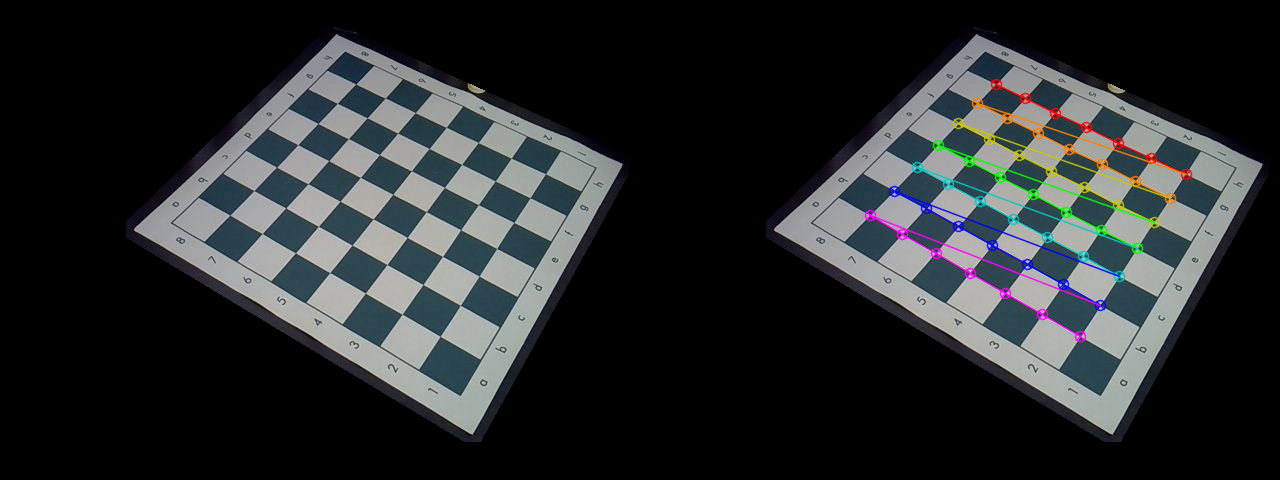

In [13]:
# convert the input image to a grayscale
gray = cv2.cvtColor(masked_original, cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, (7,7),None)

# Draw and display the corners
if ret == True:
   drawn = masked_original.copy()
   cv2.drawChessboardCorners(drawn, (7,7), corners, ret)
   cv2_imshow(np.hstack([masked_original, drawn]))
   cv2.waitKey(0)
else:
  cv2_imshow(masked_original)
  print("Ret != True, no chessboard detected")

In [22]:
def remove_background(img_name, num):
    image = cv2.imread(img_name)
    masked = cv2.bitwise_and(image, mask)
    title = "%s%i%s" % ('/content/masked_chess', num, '.jpg')
    cv2.imwrite(title, masked)

## FIND LOCATIONS FROM EACH SQUARE

## USE THE DATASET TO PREDICT EACH PIECE

<IPython.core.display.Javascript object>

Saved to /content/chess0.jpg


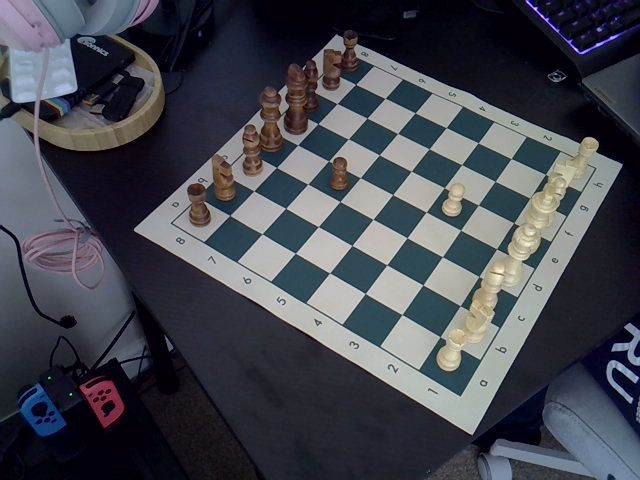

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 379.5, 'y': 232.0, 'width': 515.0, 'height': 458.0, 'confidence': 0.9509392976760864, 'class': 'Chessboard', 'image_path': '/content/masked_chess0.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 338.5, 'y': 174.0, 'width': 25.0, 'height': 40.0, 'confidence': 0.9271075129508972, 'class': 'Pawn', 'image_path': '/content/masked_chess0.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 453.0, 'y': 199.5, 'width': 28.0, 'height': 39.0, 'confidence': 0.9193568825721741, 'class': 'Pawn', 'image_path': '/content/masked_chess0.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 225.0, 'y': 180.0, 'width': 30.0, 'height': 52.0, 'confidence': 0.910603404045105, 'class': 'Knight', 'image_path': '/content/masked_chess0.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 272.5, 'y': 119.5, 'width': 31.0, 'height': 67.0, 'confidence': 0.8917897939682007, 'class': 'Queen', 'image_path': '/content/mask

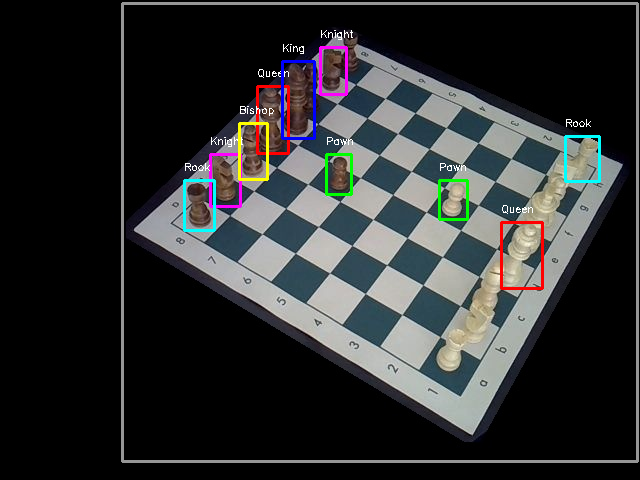

Image Saved to /content/bb0.jpg


<IPython.core.display.Javascript object>

Saved to /content/chess1.jpg


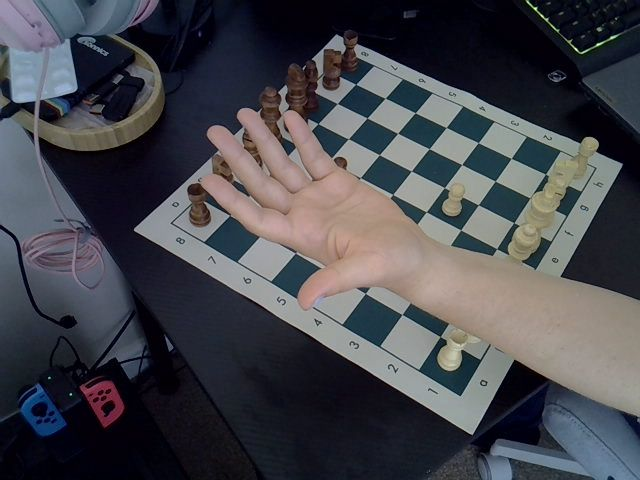

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 375.5, 'y': 225.0, 'width': 525.0, 'height': 424.0, 'confidence': 0.8169369101524353, 'class': 'Chessboard', 'image_path': '/content/masked_chess1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 332.5, 'y': 70.5, 'width': 25.0, 'height': 47.0, 'confidence': 0.788989782333374, 'class': 'Knight', 'image_path': '/content/masked_chess1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 453.0, 'y': 199.5, 'width': 28.0, 'height': 39.0, 'confidence': 0.734333336353302, 'class': 'Pawn', 'image_path': '/content/masked_chess1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 584.0, 'y': 157.0, 'width': 30.0, 'height': 42.0, 'confidence': 0.5961512327194214, 'class': 'Rook', 'image_path': '/content/masked_chess1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 351.5, 'y': 51.5, 'width': 21.0, 'height': 45.0, 'confidence': 0.5340321063995361, 'class': 'Rook', 'image_path': '/content/masked_c

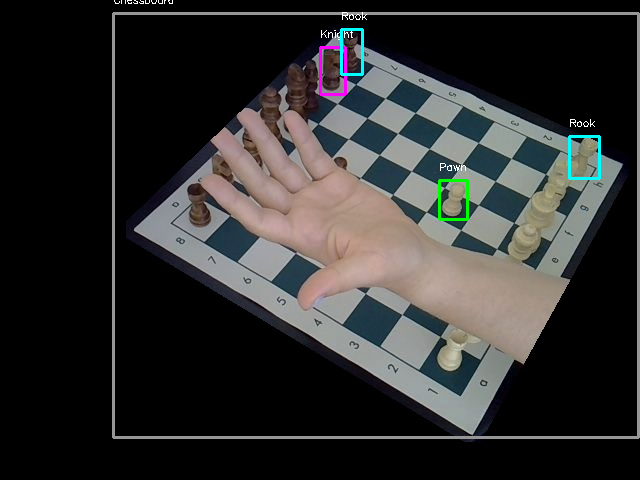

Image Saved to /content/bb1.jpg


<IPython.core.display.Javascript object>

Saved to /content/chess2.jpg


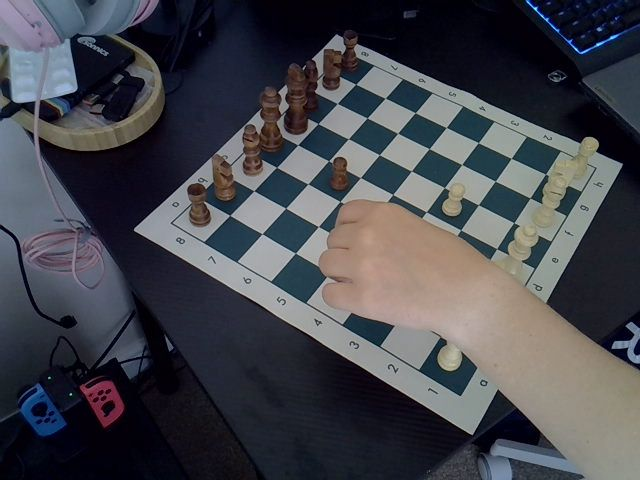

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 338.5, 'y': 173.0, 'width': 25.0, 'height': 40.0, 'confidence': 0.939933180809021, 'class': 'Pawn', 'image_path': '/content/masked_chess2.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 253.0, 'y': 150.0, 'width': 28.0, 'height': 56.0, 'confidence': 0.9022741317749023, 'class': 'Bishop', 'image_path': '/content/masked_chess2.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 378.0, 'y': 232.5, 'width': 524.0, 'height': 461.0, 'confidence': 0.9002127647399902, 'class': 'Chessboard', 'image_path': '/content/masked_chess2.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 273.0, 'y': 119.5, 'width': 30.0, 'height': 67.0, 'confidence': 0.8835357427597046, 'class': 'Queen', 'image_path': '/content/masked_chess2.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 225.5, 'y': 179.5, 'width': 29.0, 'height': 53.0, 'confidence': 0.8725188970565796, 'class': 'Knight', 'image_path': '/content/ma

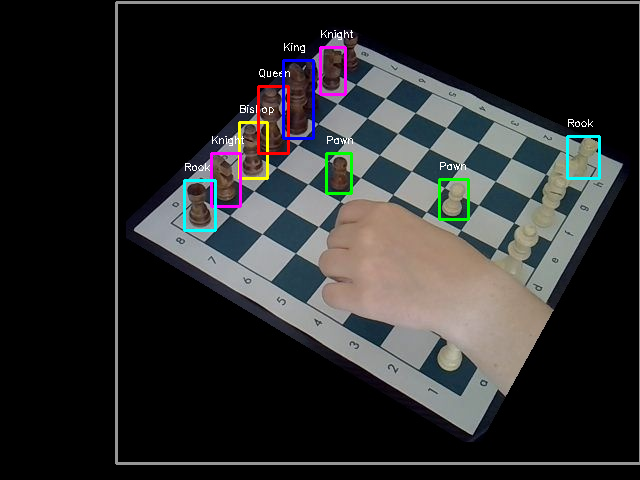

Image Saved to /content/bb2.jpg


<IPython.core.display.Javascript object>

Saved to /content/chess3.jpg


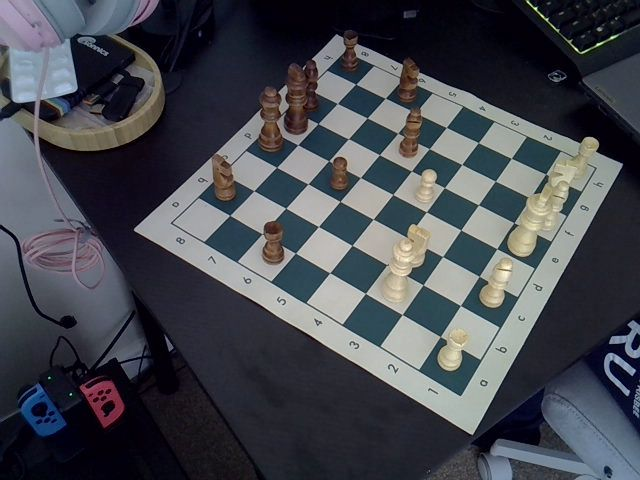

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 379.5, 'y': 231.0, 'width': 517.0, 'height': 456.0, 'confidence': 0.9659359455108643, 'class': 'Chessboard', 'image_path': '/content/masked_chess3.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 270.5, 'y': 120.5, 'width': 33.0, 'height': 71.0, 'confidence': 0.9394320249557495, 'class': 'Queen', 'image_path': '/content/masked_chess3.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 339.0, 'y': 174.0, 'width': 24.0, 'height': 40.0, 'confidence': 0.9259430170059204, 'class': 'Pawn', 'image_path': '/content/masked_chess3.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 425.0, 'y': 187.0, 'width': 28.0, 'height': 40.0, 'confidence': 0.8668185472488403, 'class': 'Pawn', 'image_path': '/content/masked_chess3.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 407.5, 'y': 81.0, 'width': 29.0, 'height': 52.0, 'confidence': 0.7285851836204529, 'class': 'Bishop', 'image_path': '/content/mask

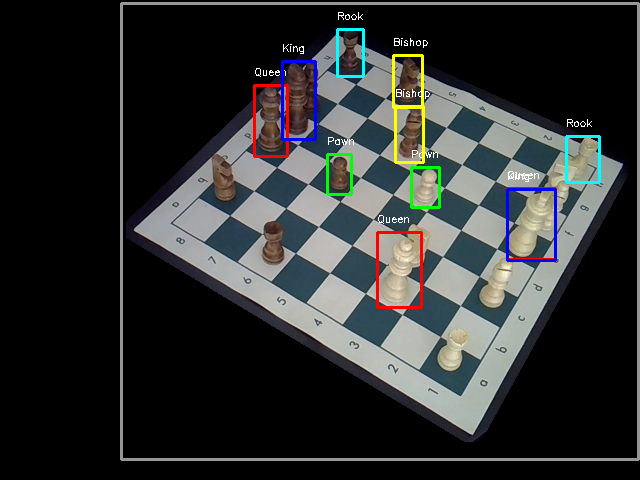

Image Saved to /content/bb3.jpg


<IPython.core.display.Javascript object>

Saved to /content/chess4.jpg


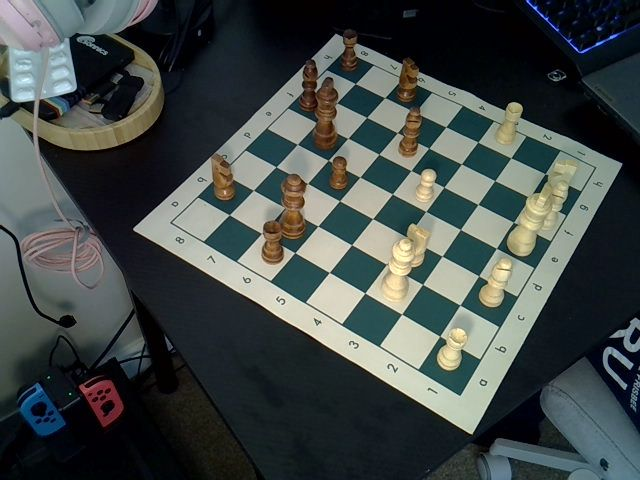

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 378.0, 'y': 235.0, 'width': 512.0, 'height': 462.0, 'confidence': 0.9589148163795471, 'class': 'Chessboard', 'image_path': '/content/masked_chess4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 338.0, 'y': 173.5, 'width': 24.0, 'height': 39.0, 'confidence': 0.9330949187278748, 'class': 'Pawn', 'image_path': '/content/masked_chess4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 424.5, 'y': 186.5, 'width': 27.0, 'height': 39.0, 'confidence': 0.8643128871917725, 'class': 'Pawn', 'image_path': '/content/masked_chess4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 408.5, 'y': 133.5, 'width': 29.0, 'height': 55.0, 'confidence': 0.8184674978256226, 'class': 'Bishop', 'image_path': '/content/masked_chess4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 293.0, 'y': 204.0, 'width': 32.0, 'height': 64.0, 'confidence': 0.5767596364021301, 'class': 'Bishop', 'image_path': '/content/ma

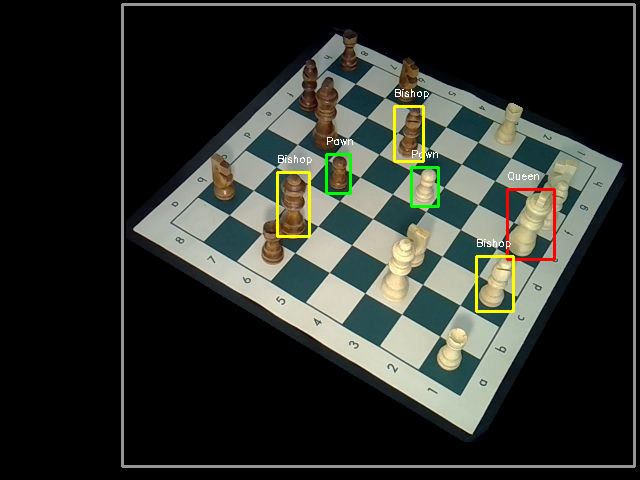

Image Saved to /content/bb4.jpg


In [23]:
for i in range(5):

  img_name = "%s%i%s" % ('/content/chess', i, '.jpg')
  take_image(img_name)
  remove_background(img_name,i)

  img_name = "%s%i%s" % ('/content/masked_chess', i, '.jpg')
  pred = get_predictions(img_name)
  draw_predictions(img_name, pred, i)
  cv2.waitKey(300)
